In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import xarray as xr
import cluster_utils as flt
import cartopy.crs as ccrs
import matplotlib.path as mpath
proj = ccrs.SouthPolarStereo()
front_colors=['black','grey','green',(218/256,165/256,32/256)]

In [15]:
ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2']
model_folder='model_20012017'

In [16]:
# Load fronts
fronts=['saf','pf','saccf','sbdy']
front_data={}
for front in fronts:
    front_data[front]=np.loadtxt('data/fronts/{}_kim.txt'.format(front))

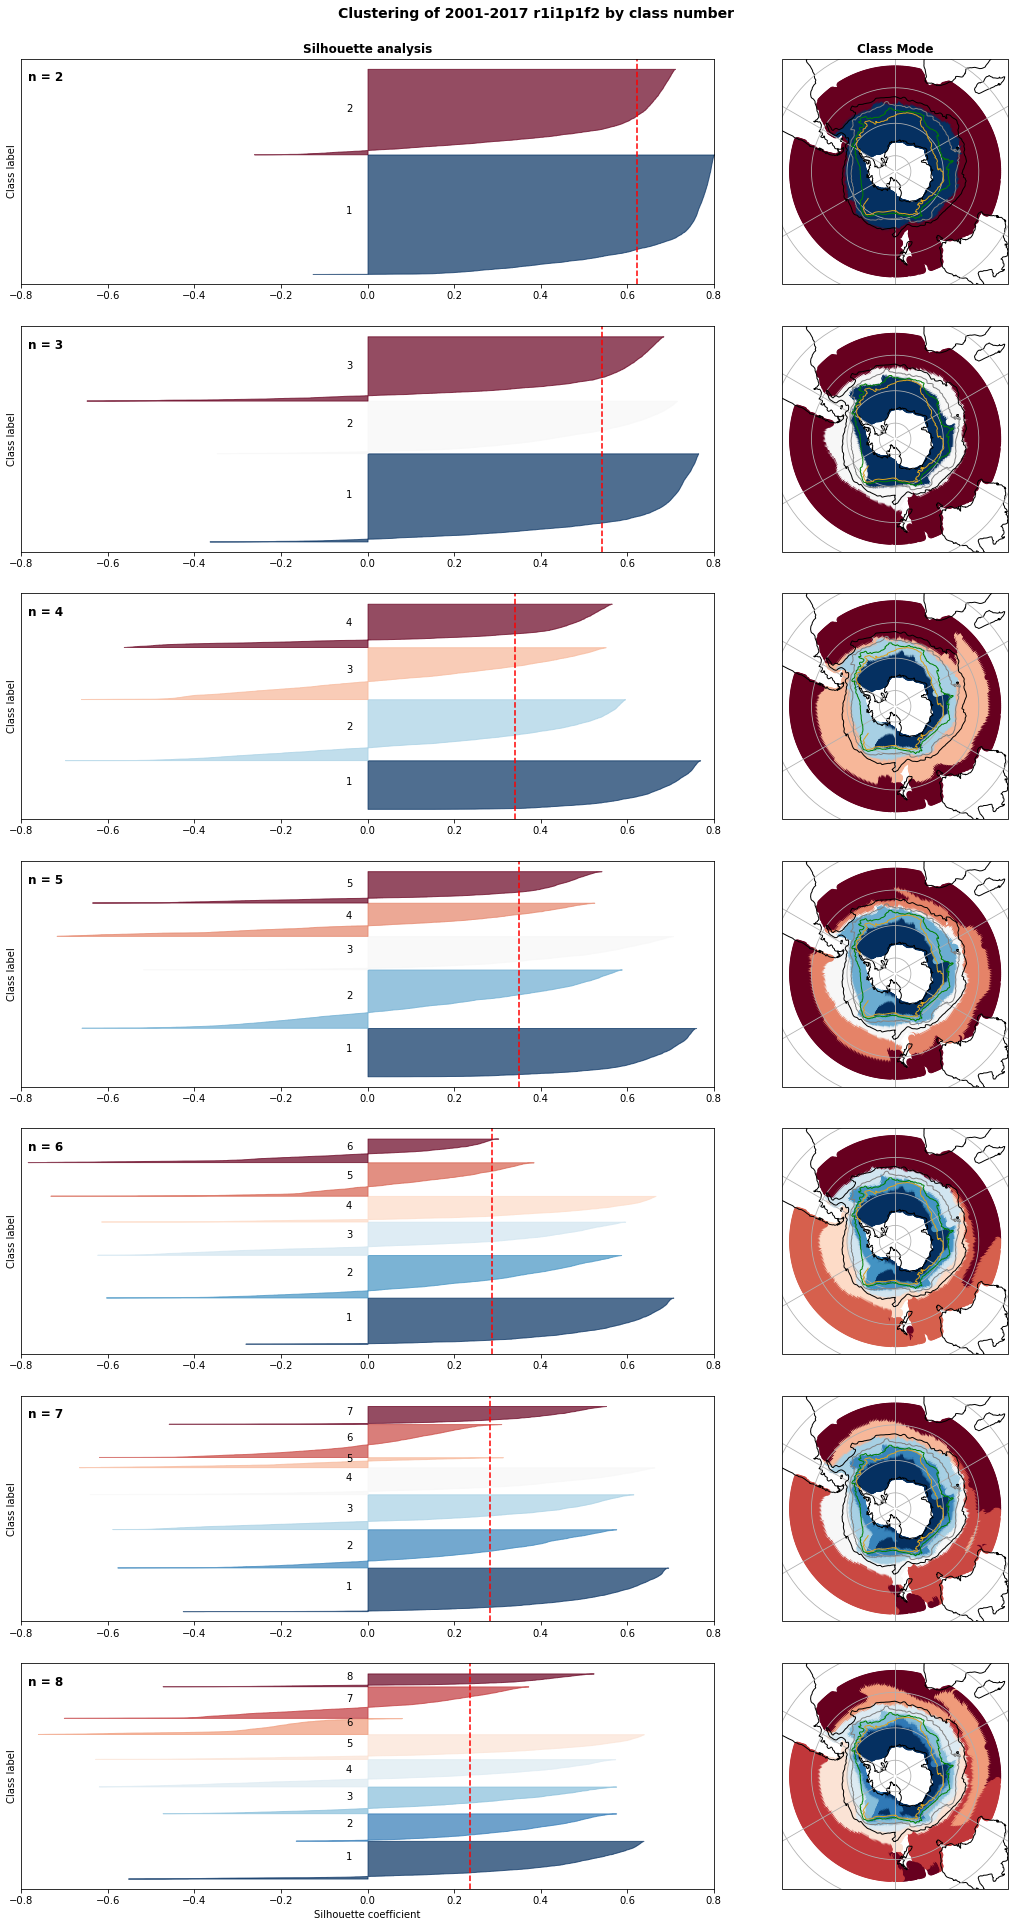

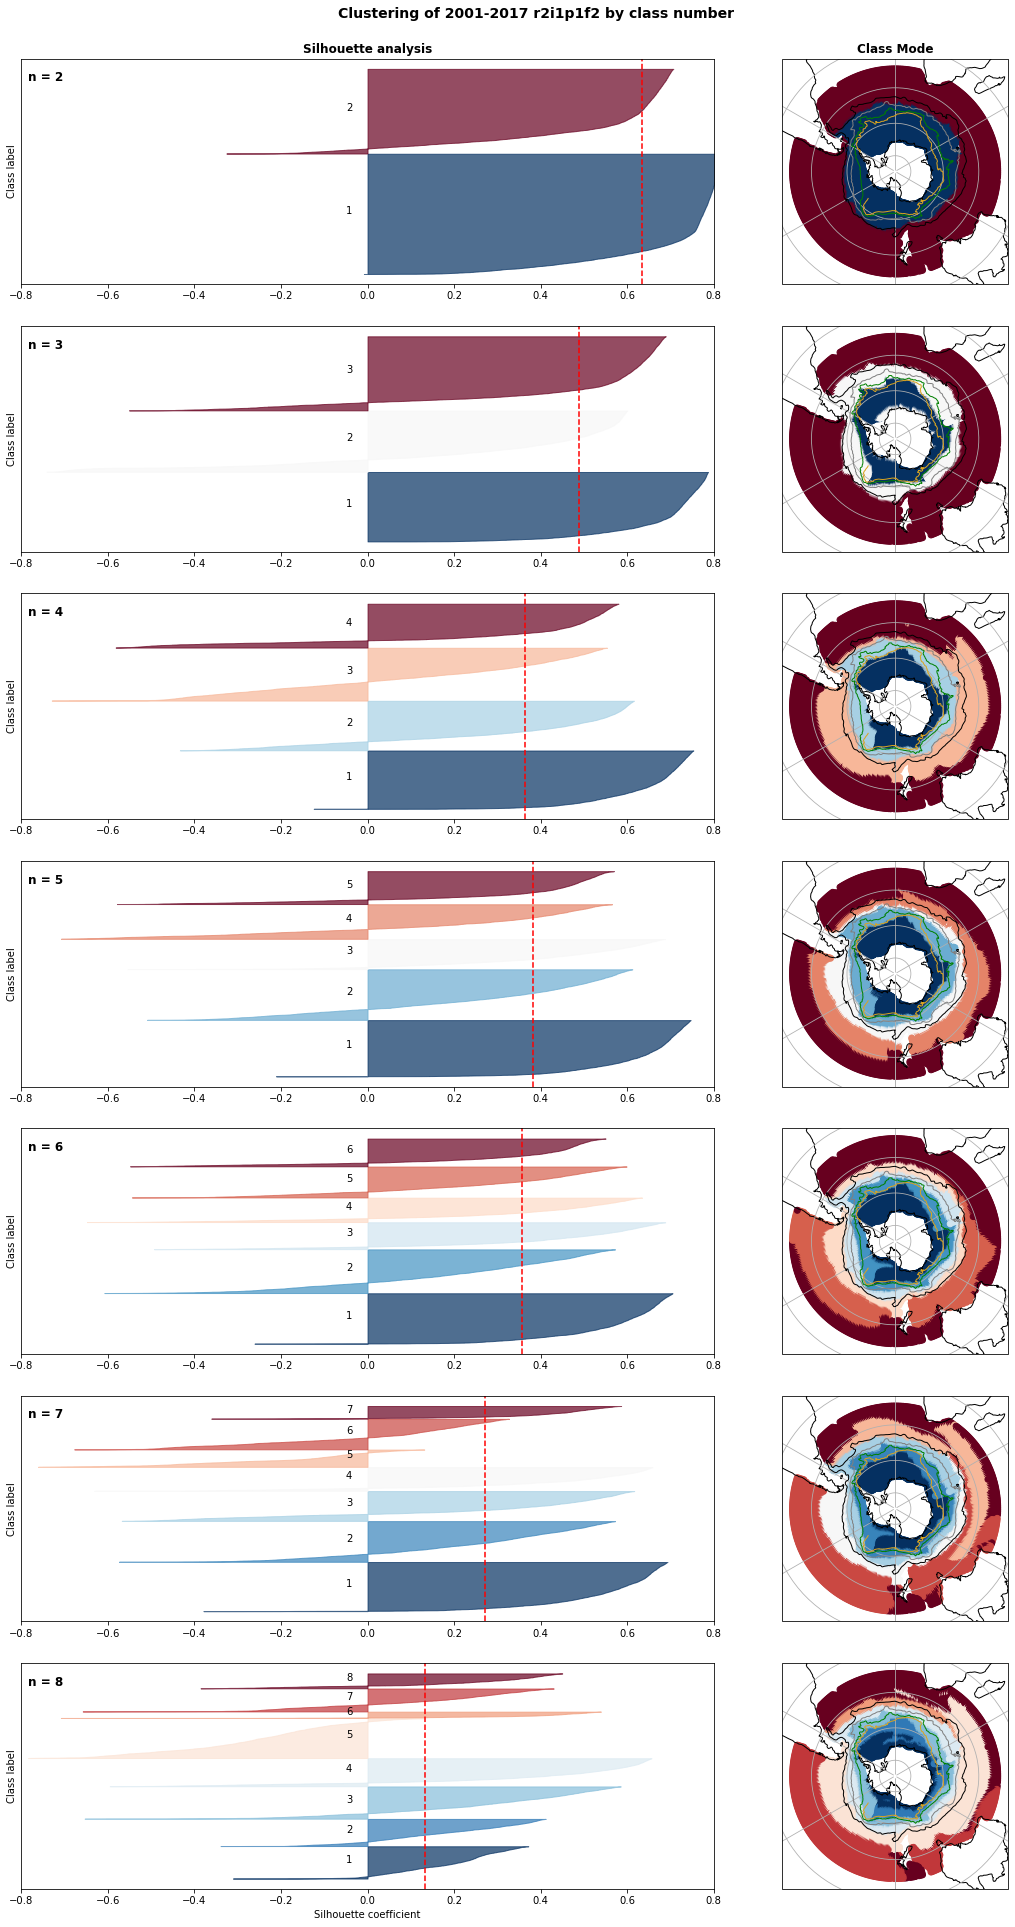

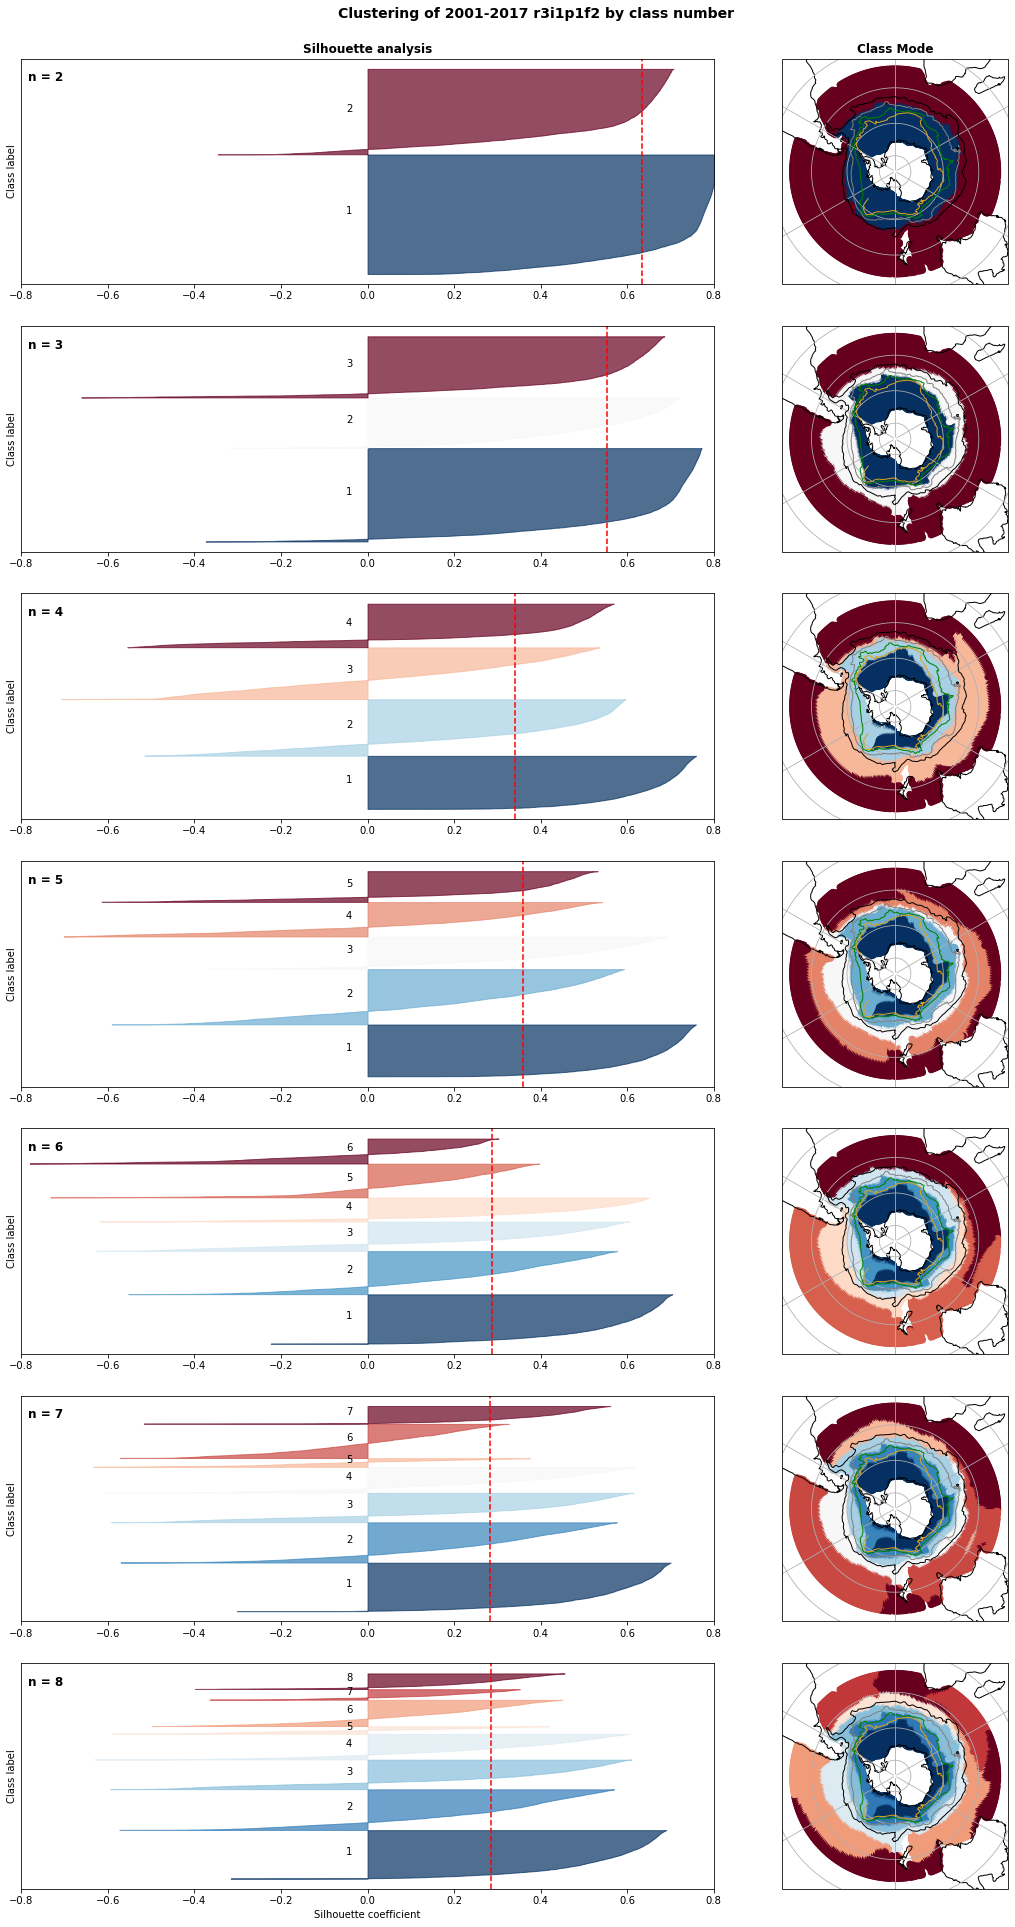

In [21]:
for m_id in ids:

    fig=plt.figure(figsize=(15,30))

    for iin,n_clusters in enumerate(range(2,9)):

       # ax=axes[n_clusters-2][0]
        #ax=fig.add_subplot(6,2,iin*2+1)
        ax=plt.subplot2grid((8,3),(iin,0),colspan=2)

        path_n = '{}/{}/{}'.format(model_folder, m_id, n_clusters)

        ax.set_xlim([-0.8, 0.8])

        with open('{}/sil.obj'.format(path_n), 'rb') as file:
                silhouette_avg   = pickle.load(file)

        # Load silhouette scores for each sample
        with open('{}/sil_vals.obj'.format(path_n), 'rb') as file:
                sample_silhouette_values   = pickle.load(file)
        with open('{}/sil_labels.obj'.format(path_n), 'rb') as file:
                cluster_labels  = pickle.load(file)

        # Open and sort profiles by surface temp  
        with open('{}/avg_prof.obj'.format(path_n), 'rb') as file:
            ref_profiles = pickle.load(file)
        inds=flt.temp_sort(None, ref_profiles, True)

        y_lower = 10

        cmap=plt.get_cmap('RdBu_r', n_clusters)

        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == inds[i]]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cmap(i)

            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        if n_clusters==8:
            ax.set_xlabel("Silhouette coefficient")
        ax.set_ylabel("Class label")
        
        ax.text(0.01,0.9,'n = {}'.format(n_clusters),fontsize=12,fontweight='bold',transform=ax.transAxes)

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
      #  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        if iin==0:
            ax.set_title(
            "Silhouette analysis",
            fontsize=12,
            fontweight="bold",
        )

       # ax=axes[n_clusters-2][1]
       # ax=fig.add_subplot(6,2,iin*2+2,projection=proj)
        ax=plt.subplot2grid((8,3),(iin,2),projection=proj)

        classes=xr.open_dataset('{}/class.nc'.format(path_n))   
        class_mode=flt.modal_classes(classes['class'],dims=['time'])
        class_sort=flt.temp_sort(class_mode,ref_profiles)    

        CS=ax.scatter(classes.lon,classes.lat,c=class_sort,cmap=cmap,transform=ccrs.PlateCarree())
        for indf,front in enumerate(fronts):
            ax.plot(front_data[front][:,0], front_data[front][:,1], lw = 1, ls='-', label=front.upper(),color=front_colors[indf],transform=ccrs.PlateCarree()) 

        ax.gridlines()
        #ax.add_feature(cfeature.LAND)
        ax.coastlines()    

        if iin==0:
            ax.set_title(
            "Class Mode",
            fontsize=12,
            fontweight="bold",
        )

        plt.suptitle('Clustering of 2001-2017 {} by class number'.format(m_id), fontsize=14,
            fontweight="bold",y=1.0)
        plt.tight_layout()

    plt.savefig('figures/sil_vsclass_{}.png'.format(m_id))